In [2]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms
import time
import mediapipe as mp
from PIL import Image
import torch.nn.functional as F
from torchvision.models import resnet18

In [3]:
class ChangeColorSpace(object):
    def __call__(self, x):
        x = np.array(x, dtype='uint8')
        hsv = cv2.cvtColor(x, cv2.COLOR_RGB2LUV)
        img = Image.fromarray(hsv)
        return img

In [5]:
transform_resnet = transforms.Compose([transforms.Resize((256, 256)),
                               ChangeColorSpace(),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                               ])

In [6]:
resnet = resnet18(weights=None)
resnet.fc = torch.nn.Linear(512, 4)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
weights_resnet = torch.load('models/best_resnet_with_augmentation_luv', map_location=device)

C:\Users\HP 2019\AppData\Local\Temp\ipykernel_24136\1464329253.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_resnet = torch.load('models/best_resnet_with_augme

In [8]:
resnet.load_state_dict(weights_resnet['model_state_dict'])

<All keys matched successfully>

In [11]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# Class Labels
class_labels = ['Paper', 'Rest', 'Rock', 'Scissor']

## Webcam

> **Note:**
> To ensure the model performs optimally, the background of the hands should consist of a single, uniform color, such as a sheet of paper, a desk, or a wall.  
> This behavior is due to the nature of the dataset on which the model was trained.

In [ ]:
# Open the Webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    try:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame. Exiting...")
            break

        # Flip the frame horizontally for a mirror-like effect
        frame = cv2.flip(frame, 1)

        # Convert the BGR image to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect Hands
        result = hands.process(rgb_frame)

        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                # Get the bounding box coordinates
                h, w, _ = frame.shape
                x_min = w
                y_min = h
                x_max = 0
                y_max = 0

                for lm in hand_landmarks.landmark:
                    x, y = int(lm.x * w), int(lm.y * h)
                    x_min = min(x_min-2, x)
                    y_min = min(y_min-2, y)
                    x_max = max(x_max+2, x)
                    y_max = max(y_max+2, y)

                # Crop the hand region
                hand_region = frame[y_min:y_max, x_min:x_max]
                if hand_region.size == 0:  # Skip if region is invalid
                    continue

                # Convert to PIL Image and Apply Transformation
                hand_image = Image.fromarray(cv2.cvtColor(hand_region, cv2.COLOR_BGR2RGB))
                
                hand_tensor = transform_resnet(hand_image).unsqueeze(0).to(device)

                # Predict with the Model
                with torch.no_grad():
                    resnet.eval()
                    prediction = resnet(hand_tensor)
                    predicted_label = class_labels[prediction.argmax(dim=1).item()]
                    probabilities = F.softmax(prediction, dim=1)
                    conf = probabilities[0][prediction.argmax(dim=1).item()]

                # Draw Bounding Box and Label
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
                cv2.putText(frame, predicted_label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv2.putText(frame, f'{conf:0.2f}', (x_min+150, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Display the Frame
        cv2.imshow("Hand Detection and Classification", frame)
        cv2.imshow('Hands', np.array(hand_image))
        cv2.imshow('Hands after transform', hand_tensor.squeeze(0).permute(2, 1, 0).numpy())
        # Exit on 'q' Key Press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    except Exception as e:
        print(e)
        cap.release()
        cv2.destroyAllWindows()
# Release the Webcam and Close Windows
cap.release()
cv2.destroyAllWindows()


## Testing on Images

Class 1: Paper with probability 0.00%
Class 2: Rest with probability 6.68%
Class 3: Rock with probability 0.00%
Class 4: Scissor with probability 93.32%


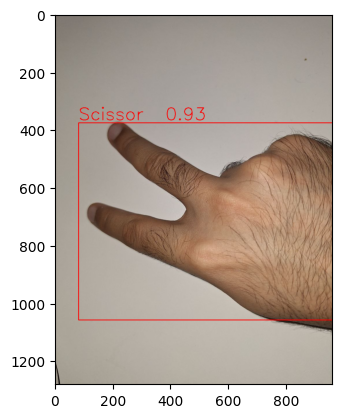

In [ ]:
frame = cv2.imread('input/scissor1.jpg')
# Convert the BGR image to RGB
rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Detect Hands
result = hands.process(rgb_frame)

if result.multi_hand_landmarks:
    for hand_landmarks in result.multi_hand_landmarks:
        # Get the bounding box coordinates
        h, w, _ = frame.shape
        x_min = w
        y_min = h
        x_max = 0
        y_max = 0

        for lm in hand_landmarks.landmark:
            x, y = int(lm.x * w), int(lm.y * h)
            x_min = min(x_min-4, x)
            y_min = min(y_min-4, y)
            x_max = max(x_max+4, x)
            y_max = max(y_max+4, y)

        # Crop the hand region
        hand_region = frame[y_min:y_max, x_min:x_max]
        if hand_region.size == 0:  # Skip if region is invalid
            continue

        # Convert to PIL Image and Apply Transformation
        hand_image = Image.fromarray(cv2.cvtColor(hand_region, cv2.COLOR_BGR2RGB))
        
        hand_tensor = transform_resnet(hand_image).unsqueeze(0).to(device)

        # Predict with the Model
        with torch.no_grad():
            resnet.eval()
            prediction = resnet(hand_tensor)
            predicted_label = class_labels[prediction.argmax(dim=1).item()]
            probabilities = F.softmax(prediction, dim=1)
            conf = probabilities[0][prediction.argmax(dim=1).item()]
        
        for i in range(4):
            class_label = class_labels[i]
            prob_percent = 100.*probabilities[0][i]
            print( f"Class {i+1}: {class_label} with probability {prob_percent:.2f}%" )
        # Draw Bounding Box and Label
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
        cv2.putText(frame, predicted_label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
        cv2.putText(frame, f'{conf:0.2f}', (x_min+300, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)

# Display the Image
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))